# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Основные шаги:**
- Загрузите данные, путь к файлу: `/datasets/autos.csv`.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Примечания:**
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
Price — цена (евро)

## Подготовка данных

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder

In [29]:
data = pd.read_csv('/datasets/autos.csv')
len_initial_data = data.shape[1]
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [31]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [32]:
#проверим актуальность выгруженной базы данных
data['DateCrawled'].max()

'2016-04-07 14:36:58'

<AxesSubplot:>

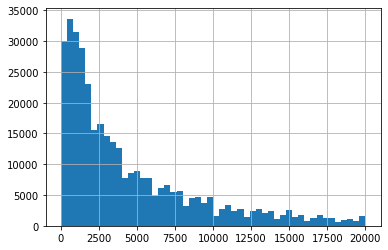

In [33]:
data['Price'].hist(bins=50)

Необходимость очистки от выбросов:
- Price - да, поскольку данные сильно смещены вправо, удалим 5% крайних значений
- RegistrationYear - да, поскольку минимальное и максимальное значения не похожи на правдоподобные. Поставим минимум на 1940, максимум на 2016 (последняя запись в столбце DateCrawled датирована 2016 г.)
- Power - да, поскольку минимальное и максимальное значения не похожи на правдоподобные. Поставим минимум на 60 л.с., максимум на 2000 л.с. (в данный момент такой мощности нет даже у серийных спорткаров)
- Kilometer - нет, данные выглядят адекватно
- RegistrationMonth, NumberOfPictures, PostalCode в дальнейшем не понадобятся

In [34]:
def del_outliers(df, col, lower, upper):
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    
    return df

In [35]:
lower = data['Price'].quantile(.025)
upper = data['Price'].quantile(.975)
data = data[(data['Price'] >= lower) & (data['Price'] <= upper)]

data = del_outliers(data, 'RegistrationYear', 1940, 2016)
data = del_outliers(data, 'Power', 60, 2000)
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,272422.000000,272422.000000,272422.000000,272422.000000,272422.000000,272422.0,272422.000000
mean,4607.312511,2002.908756,125.225844,129761.601486,5.979190,0.0,51265.899821
std,4099.267448,6.177780,61.671870,35766.398140,3.593008,0.0,25865.412427
min,0.000000,1942.000000,60.000000,5000.000000,0.000000,0.0,1067.000000
25%,1399.000000,1999.000000,88.000000,125000.000000,3.000000,0.0,30916.000000
50%,3250.000000,2003.000000,116.000000,150000.000000,6.000000,0.0,50354.000000
75%,6899.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72160.000000
max,16900.000000,2016.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


Минимальная цена все равно продолжает оставаться равной 0. Поставим нижний порог в 500 евро.

In [36]:
data = data[(data['Price'] >= 500)]
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,253939.000000,253939.000000,253939.000000,253939.000000,253939.000000,253939.0,253939.000000
mean,4928.075542,2003.179720,126.682699,129251.749436,6.071486,0.0,51541.313934
std,4063.058757,6.065482,60.368677,35791.563535,3.548878,0.0,25785.249829
min,500.000000,1942.000000,60.000000,5000.000000,0.000000,0.0,1067.000000
25%,1650.000000,1999.000000,90.000000,125000.000000,3.000000,0.0,31139.000000
50%,3590.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50825.000000
75%,7100.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72336.000000
max,16900.000000,2016.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253939 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        253939 non-null  object
 1   Price              253939 non-null  int64 
 2   VehicleType        246196 non-null  object
 3   RegistrationYear   253939 non-null  int64 
 4   Gearbox            250166 non-null  object
 5   Power              253939 non-null  int64 
 6   Model              245299 non-null  object
 7   Kilometer          253939 non-null  int64 
 8   RegistrationMonth  253939 non-null  int64 
 9   FuelType           242462 non-null  object
 10  Brand              253939 non-null  object
 11  Repaired           220570 non-null  object
 12  DateCreated        253939 non-null  object
 13  NumberOfPictures   253939 non-null  int64 
 14  PostalCode         253939 non-null  int64 
 15  LastSeen           253939 non-null  object
dtypes: int64(7), object(

In [38]:
data.isna().sum().sort_values(ascending=False)

Repaired             33369
FuelType             11477
Model                 8640
VehicleType           7743
Gearbox               3773
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [39]:
#делаем заглушку для модели автомобиля, типа автомобиля и факта ремонта - меняем на 'unknown'
data[['Model', 'Repaired', 'VehicleType', 'FuelType', 'Gearbox']] = data[['Model', 'Repaired', 'VehicleType', 'FuelType', 'Gearbox']].fillna('unknown')

In [40]:
data[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']].corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
Price,1.000000,0.502412,0.361884,-0.376547,0.054031,NaN
RegistrationYear,0.502412,1.000000,0.023872,-0.331625,0.034448,NaN
Power,0.361884,0.023872,1.000000,0.126571,0.019976,NaN
Kilometer,-0.376547,-0.331625,0.126571,1.000000,-0.011319,NaN
RegistrationMonth,0.054031,0.034448,0.019976,-0.011319,1.000000,NaN
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN


Наблюдаются слабая прямая взаимосвязь цены с годом производства автомобиля и мощностью, слабая обратная взаимосвязь - с пробегом.

In [41]:
#сравнение категориальных переменных
def categories_difference(df, ind_var, dep_var_list):
    for dv in dep_var_list:
        print(df.groupby(dv, dropna=False)[ind_var].mean().sort_values(ascending=False), '\n\n')

In [42]:
cat_vars_list = ['VehicleType', 'Gearbox', 'FuelType',
       'Repaired']
categories_difference(data, 'Price', cat_vars_list)

VehicleType
suv            8412.037464
convertible    6468.256085
coupe          5804.377622
bus            5443.275585
wagon          5005.219968
sedan          4801.417669
other          4148.666018
small          3608.031209
unknown        3215.323776
Name: Price, dtype: float64 


Gearbox
auto       6691.133576
manual     4488.173790
unknown    3628.849457
Name: Price, dtype: float64 


FuelType
hybrid      9519.414365
electric    8180.440000
gasoline    6432.670150
cng         4901.061002
petrol      4273.483560
lpg         4232.264206
other       3561.022727
unknown     3320.243792
Name: Price, dtype: float64 


Repaired
no         5399.557564
unknown    3600.380533
yes        2629.290945
Name: Price, dtype: float64 




In [43]:
#смотрим на разницу цен среди моделей и брендов автомобилей
data.groupby(['Brand', 'Model'])['Price'].mean().sort_values(ascending=False)

Brand          Model            
mercedes_benz  gl                   14399.500000
audi           q7                   14301.262295
               q5                   13892.921569
               a5                   13844.782772
land_rover     range_rover_sport    13446.515152
                                        ...     
daihatsu       move                   934.000000
lancia         elefantino             933.000000
daewoo         lanos                  855.692308
trabant        other                  800.000000
rover          defender               550.000000
Name: Price, Length: 335, dtype: float64

In [44]:
#убираем ненужные столбцы
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253939 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             253939 non-null  int64 
 1   VehicleType       253939 non-null  object
 2   RegistrationYear  253939 non-null  int64 
 3   Gearbox           253939 non-null  object
 4   Power             253939 non-null  int64 
 5   Model             253939 non-null  object
 6   Kilometer         253939 non-null  int64 
 7   FuelType          253939 non-null  object
 8   Brand             253939 non-null  object
 9   Repaired          253939 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.3+ MB


In [45]:
#проверка на дубликаты
data.duplicated().sum()

33500

In [46]:
#убираем дубликаты и делаем повторную проверку
data = data.drop_duplicates()
data.duplicated().sum()

0

In [47]:
#смотрим на получившийся df
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220439 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             220439 non-null  int64 
 1   VehicleType       220439 non-null  object
 2   RegistrationYear  220439 non-null  int64 
 3   Gearbox           220439 non-null  object
 4   Power             220439 non-null  int64 
 5   Model             220439 non-null  object
 6   Kilometer         220439 non-null  int64 
 7   FuelType          220439 non-null  object
 8   Brand             220439 non-null  object
 9   Repaired          220439 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.5+ MB


In [48]:
#меняем тип переменных на категориальные
categories=['VehicleType', 'Gearbox', 'Brand', 'Model', 'Repaired', 'FuelType']
data[categories] = data[categories].astype('category')

In [49]:
len_preprocessed_data = data.shape[1]
print(f'После обработки утрачено {(1 - len_preprocessed_data / len_initial_data):.2%}')

После обработки утрачено 37.50%


In [50]:
#делим данные
target = data['Price']
features = data.drop(columns=['Price'])
train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                                                    test_size=.2, 
                                                                                    random_state=123)

#проводим One Hot Encoding, прописываем drop='first', чтобы избавиться от дамми ловушки
ohe = OneHotEncoder(drop='first')
train_features_ohe = ohe.fit_transform(train_features[['VehicleType', 'Gearbox', 'FuelType', 'Repaired']]).toarray()
test_features_ohe = ohe.transform(test_features[['VehicleType', 'Gearbox', 'FuelType', 'Repaired']]).toarray()

#проводим Mean Estimator Encoding, чтобы уменьшить число дамми-переменных модели и бренда
mee = MEstimateEncoder(random_state=42)
train_features_mee = mee.fit_transform(train_features[['Brand', 'Model']], train_target).to_numpy()
test_features_mee = mee.transform(test_features[['Brand', 'Model']], test_target).to_numpy()

scaler = StandardScaler()
train_features[['RegistrationYear', 'Power', 'Kilometer']] = scaler.fit_transform(train_features[['RegistrationYear', 'Power', 'Kilometer']])
test_features[['RegistrationYear', 'Power', 'Kilometer']] = scaler.transform(test_features[['RegistrationYear', 'Power', 'Kilometer']])

#объединяем закодированные и стандартизированные данные в единый массив (для обучения линейной регрессии и случайного леса)
train_features_enc = np.concatenate([train_features_ohe, 
                                     train_features_mee, 
                                     train_features[['RegistrationYear', 'Power', 'Kilometer']].to_numpy()], axis=1)
test_features_enc = np.concatenate([test_features_ohe, 
                                    test_features_mee,
                                    test_features[['RegistrationYear', 'Power', 'Kilometer']].to_numpy()], axis=1)

train_features_enc.shape, test_features_enc.shape

C:\Users\artyo\AppData\Local\Temp/ipykernel_20872/1568531135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[['RegistrationYear', 'Power', 'Kilometer']] = scaler.fit_transform(train_features[['RegistrationYear', 'Power', 'Kilometer']])
C:\Users\artyo\practicum\practicum_env\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\artyo\AppData\Local\Temp/ipykernel_20872/1568531135.py:

((176351, 24), (44088, 24))

**Выводы:**
- убраны аномалии в столбцах с числовыми переменными
- убраны NA в категориальных переменных
- убраны дубликаты
- категориальные переменные для целей машинного обучения приведены к типу данных category
- в результате обработки датафрейма осталось 69.42% от исходного
- данные разделены на обучающую и тестовые выборки

## Обучение моделей

In [51]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(train_features_enc, train_target)

Wall time: 238 ms


LinearRegression()

In [52]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_boost_round': 500, 
    'feature_fraction': 0.75, 
    'random_state': 123, 
    'metric': 'mse',
    'learning_rate': 0.2,
    'early_stopping_round': 3,
    'max_depth': 12,
    'num_leaves': 144,
    'verbose': 2
    }

train_data = lgb.Dataset(train_features, label=train_target, categorical_feature=categories)
test_data = lgb.Dataset(test_features, label=test_target, reference=train_data)

light = lgb.train(params, train_data, verbose_eval=200, valid_sets=[train_data, test_data])

C:\Users\artyo\practicum\practicum_env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\artyo\practicum\practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\artyo\practicum\practicum_env\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'Repaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\artyo\practicum\practicum_env\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771598
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.183798
[LightGBM] [Debug] init for col-wise cost 0.007003 seconds, init for row-wise cost 0.008705 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 176351, number of used features: 9
[LightGBM] [Info] Start training from score 5002.191164
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 11
Training until validation scores don't improve for 3 rounds
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12

C:\Users\artyo\practicum\practicum_env\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\artyo\practicum\practicum_env\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth

In [53]:
%%time
params = {'n_estimators': range(10, 121, 50),
              'max_depth': [5, 7],
              'min_samples_split': range (4,10,2)}
rfr = RandomForestRegressor(criterion = "mse", random_state=42, n_jobs=-1)
grid = GridSearchCV(rfr, params, cv=5, verbose=2)
grid.fit(train_features_enc, train_target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=10; total time=   6.3s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=10; total time=   1.7s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=10; total time=   1.6s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=10; total time=   1.7s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=10; total time=   1.7s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=60; total time=   7.9s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=60; total time=   7.9s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=60; total time=   7.9s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=60; total time=   8.0s
[CV] END ..max_depth=5, min_samples_split=4, n_estimators=60; total time=   8.5s
[CV] END .max_depth=5, min_samples_split=4, n_estimators=110; total time=  14.6s
[CV] END .max_depth=5, min_samples_split=4, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [5, 7],
                         'min_samples_split': range(4, 10, 2),
                         'n_estimators': range(10, 121, 50)},
             verbose=2)

In [54]:
best_model = grid.best_estimator_
best_model

RandomForestRegressor(max_depth=7, min_samples_split=8, n_estimators=110,
                      n_jobs=-1, random_state=42)

**Выводы по этапу:**
- были натренированы и обучены модели линейной регрессии, случайного леса (с подбором параметров через GridSearchCV) и градиентного бустинга LightGBM
- самой быстрой моделью оказалась модель линейной регрессии, на обучение LightGBM ушло около 51 минут, случайного леса - 5 часов 21 минута

## Анализ моделей

In [55]:
%%time
predictions_lr = lin_reg.predict(test_features_enc)
mean_squared_error(test_target, predictions_lr, squared=False)

Wall time: 8.98 ms


2592.5772995489174

In [56]:
%time
predictions_lgb = light.predict(test_features)
mean_squared_error(test_target, predictions_lgb, squared=False)

Wall time: 0 ns


1459.7040948555461

In [57]:
%time
predictions_best_rfr = best_model.predict(test_features_enc)
mean_squared_error(test_target, predictions_best_rfr, squared=False)

Wall time: 0 ns


1934.5997378296197

**Выводы:**
- быстрее всех предсказания выдает модель градиентного бустинга, на втором месте - случайный лес, на третьем - линейная регрессия
- точнее всех предсказания выдает модель градиентного бустинга, лучшая модель случайного леса также прошла порог RMSE < 2500, предсказания линейного регрессии наименее точные

**Общий вывод:** наиболее точной и относительной быстрой (51 мин) оказалась модель градиентного бустинга LightGBM, также хорошо себя показали предсказания лучшей модели случайного леса, однако обучение и подбор гиперпараметров заняли более 5 часов. Кроме того, при работе с LightGBM не пришлось самостоятельно создавать dummy-переменные из категориальных признаков.